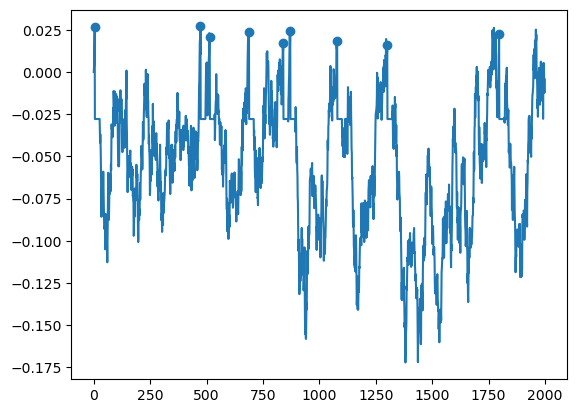

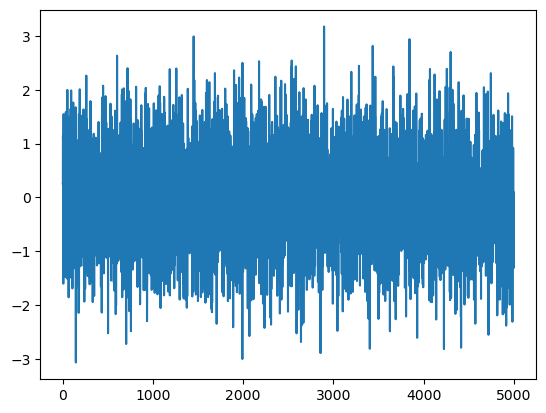

In [74]:
# import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt


def get_noisy_current_OU( t_end, unit_time, I_stim0, I_avg, tau_n = 10, sig_noise = 1, myseed=10):

    """Creates a noise injection using Ornstein-Uhlenbeck (OU) process.
    Args:
        t_end (int): end of the step in ms
        unit_time (Brian2 unit): unit of t_start and t_end. e.g. 0.1*brian2.ms
        I_stim0 (int): inital value for the injected current
        unit (Quantity): unit of the current usually uA
        tau_n (Quantity): noise time constant
        sig_noise (Quantity): standard deviation of noise 

    Returns:
        TimedArray: Brian2.TimedArray
    """


    # Retrieve simulation parameters
    dt = 1. * unit_time
    Lt =  t_end

    # Set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # Generate GWN
    # we divide here by 1000 to convert units to sec.
    I_gwn = np.zeros((int(Lt/dt),1))


    I_stim = np.zeros((int(t_end/dt)))
    I_stim[0] = I_stim0
 
    for t_ in range(0,int(t_end/dt)):
        I_stim[t_]=I_avg+((I_avg-I_stim[t_-1])/tau_n)+sig_noise*np.random.normal(0,1)
    
    I_gwn[:,0] = I_stim

    tmp = I_gwn
    curr = tmp #TimedArray(tmp, dt=1. * unit_time)
    return curr

default_pars = {'V_th': 0.0279, 'V_reset': -0.0279, 'tau_m': 10.0,
                'g_L': 1.0, 'V_init': 0, 'E_L': 0.0, 'tref': 2.0,
                'T': 500.0, 'dt': 0.1,
                'range_t': np.arange(2000),'seed':0}

def run_LIF(pars,  stop=False):
    """
    Simulate the LIF dynamics with external input current

    Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value
                    or an array
    stop       : boolean. If True, use a current pulse

    Returns:
    rec_v      : membrane potential
    rec_sp     : spike times
    """

    # Set parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m, g_L = pars['tau_m'], pars['g_L']
    V_init, E_L = pars['V_init'], pars['E_L']
    dt, range_t = pars['dt'], pars['range_t']
    T = pars['T']
    # print(T)
    seed = pars['seed']
    Lt = range_t.size
    tref = pars['tref']
    # Initialize voltage
    v = np.zeros(Lt)
    v[0] = V_init

    SNR = 0.6
    st= get_noisy_current_OU(int(T), dt,0,0,myseed=seed)
    nt=get_noisy_current_OU(int(T), dt,0,0,myseed=seed)
    Iinj = SNR*st + np.sqrt(1-SNR)*nt
    rec_spikes = []  # record spike times
    tr = 0.  # the count for refractory duration

    for it in range(Lt - 1):

        if tr > 0:  # check if in refractory period
            v[it] = V_reset  # set voltage to reset
            tr = tr - 1 # reduce running counter of refractory period

        elif v[it] >= V_th:  # if voltage over threshold
            rec_spikes.append(it)  # record spike event
            v[it] = V_reset  # reset voltage
            tr = tref / dt  # set refractory time

        # Calculate the increment of the membrane potential
        dv = (-(v[it]-E_L)+Iinj[it]/g_L)* (dt / tau_m)

        # Update the membrane potential
        v[it + 1] = v[it]+dv

        # Get spike times in ms
        rec_spikes_ = np.array(rec_spikes) * dt

    return v, rec_spikes_,Iinj
spikes_t_s_u = []
spikes_t_s_r = []
N_stim = 100

for i in range(N_stim):
    default_pars['seed'] = i
    v, spikes, st = run_LIF(default_pars)
    # For autocorrelation
    spikes_t_s_u.append(spikes)

    # For cross-correlation
    default_pars['seed'] = 0
    v, spikes, nt = run_LIF(default_pars)
    spikes_t_s_r.append(spikes)

# for i in range(N_stim):
#     default_pars['seed']=i
#     v,spikes,I =run_LIF(default_pars,)
#     spikes_t_s_u.append(spikes)
plt.plot(v)
plt.scatter(np.array(spikes/0.1-0.01,dtype=np.int32),v[np.array(spikes/0.1-0.01,dtype=np.int32)])
plt.show()
plt.plot(nt)
plt.show()

In [75]:
for i in spikes_t_s_r:
    print(len(i))

16
16
12
8
7
9
9
10
13
9
16
18
17
7
12
11
12
8
9
16
11
14
11
13
11
15
10
19
12
11
12
16
18
14
12
14
12
9
15
14
10
12
16
13
10
18
11
15
14
12
14
13
18
15
15
13
14
14
11
14
13
9
10
8
6
10
18
17
14
8
11
18
5
14
11
7
16
7
11
8
10
13
14
16
12
14
12
13
8
10
14
11
14
7
13
16
9
18
13
9


In [76]:
for i in spikes_t_s_u:
    print(len(i)) 
    

15
20
10
11
23
17
20
9
27
21
13
18
12
15
14
9
18
27
24
11
12
10
21
8
12
19
13
21
16
19
18
15
12
18
11
15
17
16
22
10
19
14
26
21
12
14
17
23
19
16
15
13
15
9
9
20
18
18
11
25
9
10
18
20
11
14
21
13
16
15
15
16
16
13
18
25
19
17
24
21
25
18
17
16
14
20
14
19
27
17
20
16
21
13
17
15
16
17
19
22


In [77]:
#1. Generate 100 spike trains for different OU inputs 
# Changed the Nstim to 100
#2. Generate 100 spike for the same OU input 

In [78]:
from scipy.io import loadmat
import numpy as np
spikesmat_tsu = loadmat(r"C:\Users\maria\Desktop\Internship\Code_SNArticle\Sim_data_Nishant\spikes_tsu.mat")
spikesmat_tsr = loadmat(r"C:\Users\maria\Desktop\Internship\Code_SNArticle\Sim_data_Nishant\spikes_tsr.mat")


In [79]:
print(len(spikesmat_tsu['t_s_u'][0][0]))
# print('--------------------1-----1-----1')

1000


In [80]:
spikesmat_tsu['t_s_u'][0][0].shape

(1000, 1)

In [81]:
test_spike_t_s_u = np.array(spikesmat_tsu['t_s_u'])[0][0][:10]
test_spike_t_s_r = np.array(spikesmat_tsr['t_s_r'])[0][0][:10]


In [82]:
for i in test_spike_t_s_u:
    print(len(i[0][0]))

554
491
473
519
528
504
523
515
490
503


In [83]:
s1 = np.repeat(np.expand_dims(np.array([1,2]),axis=0).T,2,axis=1)
s2 = np.repeat(np.expand_dims(np.array([1,2]),axis=1).T,2,axis=0)
print(s1-s2+10/(2*(0.1**2)))


[[500. 499.]
 [501. 500.]]


In [84]:
def auto_corr(plot_taus,sigma,t_s):
    Ntr = np.shape(t_s)[1]
    
    # auto_corr = np.zeros((len(plot_taus),1))
    auto_corr = []
    for k in range(Ntr):
        auto_corr_temp = []
        ST1= t_s[0][k][0]

        N = len(ST1)

        s1 = np.repeat(np.expand_dims(ST1.T,axis=0).T,N,axis=1)
        s2 = np.repeat(np.expand_dims(ST1,axis=1).T,N,axis=0)
        for i in range(len(plot_taus)):
            tau = plot_taus[i]
            cons_a = np.exp(-((s1-s2+tau)**2)/(2*(sigma**2)))
            cons_b = np.exp(-(tau)**2/(2*(sigma**2)))
            auto_corr_temp.append((np.sum(cons_a)-N*cons_b)/(np.sqrt(2*np.pi)*sigma))
        auto_corr.append(auto_corr_temp)
    auto_corr=np.mean(auto_corr,axis=0)
    return np.expand_dims(auto_corr,axis=1)

def cross_corr(plot_taus,sigma,t_s):
    
    Ntr =np.shape(t_s)[1]
    cross_corr = np.zeros((len(plot_taus),1))
    t_s1 = t_s[0]
    t_s2 = t_s[0][1:]
    for k in range(Ntr-1):
        ST1 = t_s1[k][0]
        ST2 = t_s2[k][0]
        l1 = len(ST1)
        l2 = len(ST2)
        sig1 = np.expand_dims(ST1,axis=0)
        sig2 = np.expand_dims(ST2,axis=0)
        s1 = np.repeat(sig1.T,l2,axis=1)
        s2 = np.repeat(sig2,l1,axis=0)

        for i in range(len(plot_taus)):
            tau = plot_taus[i]
            cons = np.exp(-(s1-s2+tau)**2/(2*sigma**2))
            cross_corr[i] +=np.sum(cons)/(np.sqrt(2*np.pi)*sigma)

    cross_corr=cross_corr/(Ntr-1)
    return cross_corr

def My_DFT_custom_freqs(t,x,freqs):
    # %MY_DFT Gives the discrete fouriertransform for an input of a time vector t
    # % and the function x that will be fouriertransformed. 
    # %   Also we could introduce a custom freqs vector in the future to
    # %   customize the frequency resolution.
    print(x.shape)
    f_coefs = np.zeros((1,len(freqs)))
    
    
    T_seq = np.max(t) - np.min(t)
    for k in range(f_coefs.shape[1]):
        # print(np.exp(-1j*2*np.pi*freqs[k]*t[:-1]))
        f_coefs[0,k] = np.real(np.mean(x[0,:-1]*(np.exp(-1j*2*np.pi*freqs[k]*t[:-1]))))
    
    return f_coefs


In [85]:

num_tau_min  = -100  #% (ms)
num_tau_max =  100  #% (ms)
num_dtau    =  0.1  #% (ms)

                  
num_taus = np.arange(num_tau_min,num_tau_max+num_dtau,num_dtau)

sigma =0.01
autocor_num_u = auto_corr(num_taus,sigma,test_spike_t_s_u[:10].T)  # what is sigma?
crosscorr_num_r  = cross_corr(num_taus, sigma, test_spike_t_s_r[:10].T)#
            

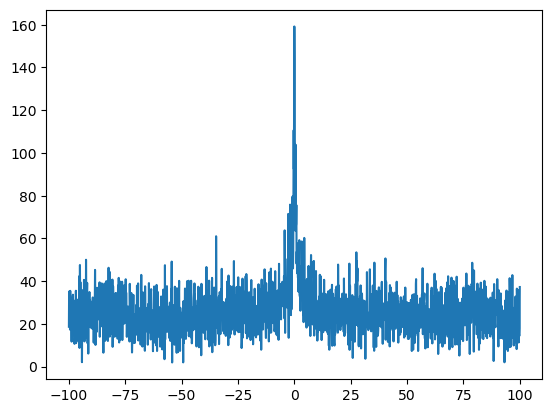

In [86]:
# plot for the spike cross-correlation
plt.plot(num_taus,crosscorr_num_r)

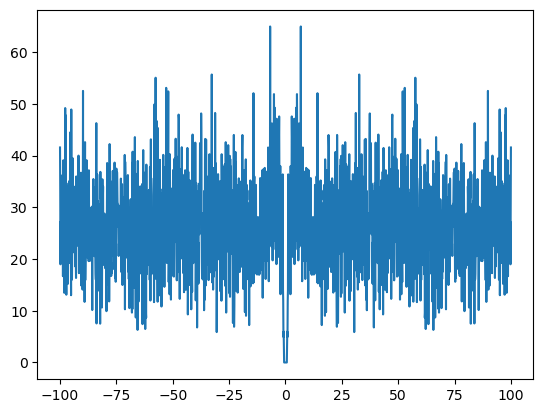

In [87]:
# Plot for the spike autocorrelation
plt.plot(num_taus,autocor_num_u)


In [88]:
   
freq_max = 500 # Max frequency to evaluate (Hz)

delta_f = 1 

# Assigning vectors
freqs = np.arange(0,freq_max+delta_f, delta_f) #;

#number of frequencies
Nf = len(freqs)

num_delta_f = 1/(num_tau_max-num_tau_min)*1000
num_freqs   = np.arange(0,(1/num_dtau*1000/2)+num_delta_f, num_delta_f)/1000
steps = 10000
dt = 0.1
T_seq_korrigiert = steps*dt
N = 1
Ntr = 10
FiR_u = np.zeros((1,Ntr))
FiR_r = np.zeros((1,Ntr))


for j  in range(Ntr):
   FiR_u[0,j] = len(test_spike_t_s_u.T[0,j][0])/T_seq_korrigiert
   FiR_r[0,j] = len(test_spike_t_s_r.T[0,j][0])/T_seq_korrigiert

FiR_u_mean = np.mean(FiR_u)
FiR_r_mean = np.mean(FiR_r)
# % Fouriertranformations

Off_Fac_num_u = 1/(num_tau_max-num_tau_min)*FiR_u_mean*T_seq_korrigiert

# %  Numeric functions
auto_four_u_temp   = np.real(My_DFT_custom_freqs(num_taus, autocor_num_u.T, num_freqs))
auto_four_u  = np.real(auto_four_u_temp)

cross_four_r_temp  = np.real(My_DFT_custom_freqs(num_taus, crosscorr_num_r.T, num_freqs))
cross_four_r = np.real(cross_four_r_temp)

Info_pn_cor2  = -1/2*np.log2(1-(cross_four_r/(auto_four_u+Off_Fac_num_u))) 


Total_info_rate = np.sum(Info_pn_cor2)


(1, 2001)
(1, 2001)


In [89]:
print("Information Rate per frequency (Info_pn_cor2):")
print(Info_pn_cor2)

print("Total Information Rate (Total_info_rate):")
print(Total_info_rate)

Information Rate per frequency (Info_pn_cor2):
[[1.58126465 0.81426466 1.12836752 ... 0.00696909 0.05859929 0.17872489]]
Total Information Rate (Total_info_rate):
25.300894079740235


Text(250, 1.5, 'Total Info Rate: 25.30 bits/sec')

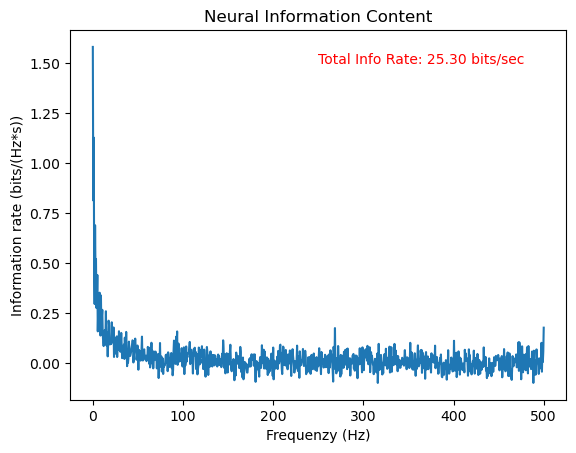

In [90]:
plt.plot(num_freqs*100,Info_pn_cor2[0])
plt.xlabel("Frequenzy (Hz)")
plt.ylabel("Information rate (bits/(Hz*s))")
plt.title("Neural Information Content")
plt.text(250, 1.5, f'Total Info Rate: {Total_info_rate:.2f} bits/sec', color='r')
